In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import scipy as sp
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [2]:
dataframe = pd.read_csv('../data/processed/clean_food_and_cities.csv')

# Distribution of the products per nutrition grade

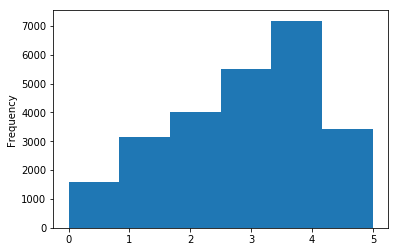

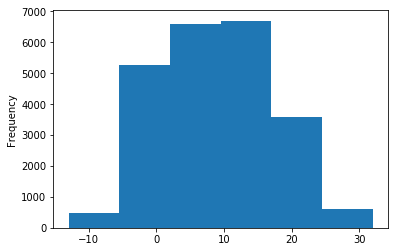

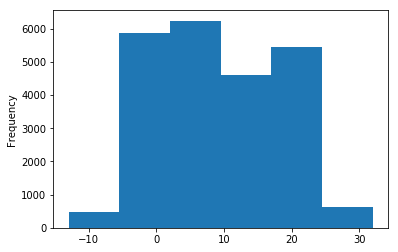

In [6]:
# we plot the general distribution of the nutrition grade for all remaining products
dataframe['nutrition_grade_numeric'].plot.hist(bins=6)
plt.show()

# we plot the general distribution of the nutrition score fr for all remaining products
dataframe['nutrition-score-fr_100g'].plot.hist(bins=6)
plt.show()

# we plot the general distribution of the nutrition score uk for all remaining products
dataframe['nutrition-score-uk_100g'].plot.hist(bins=6)
plt.show()

We see that most of the products are labeled with a `3` or below, which indicates that healthy products are rare in comparison. 

Reminder: `0` is equivalent to no data.

# Correlation between income and "quality" of the available products

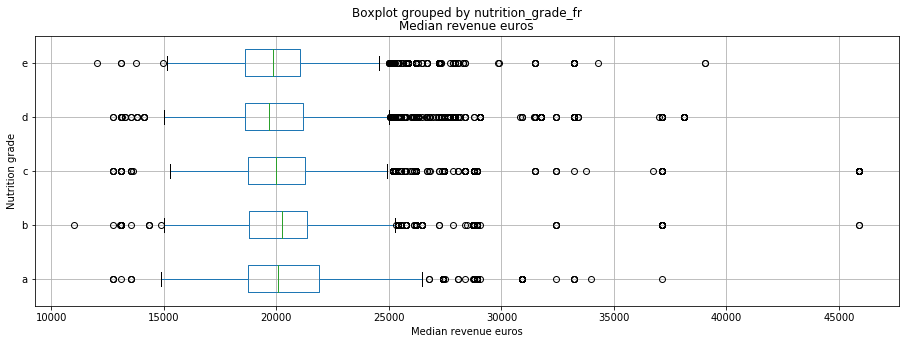

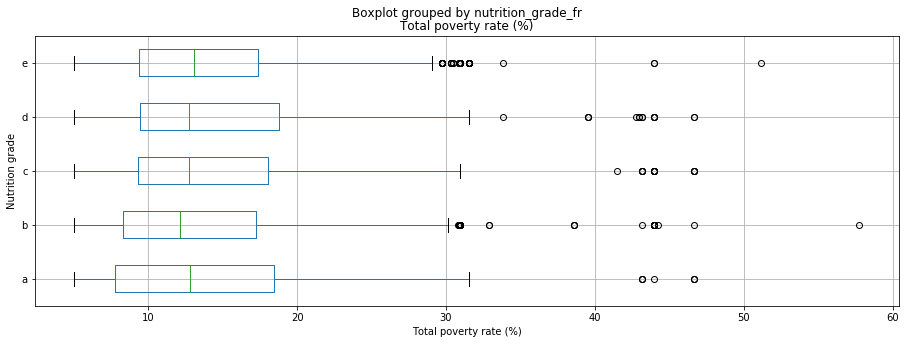

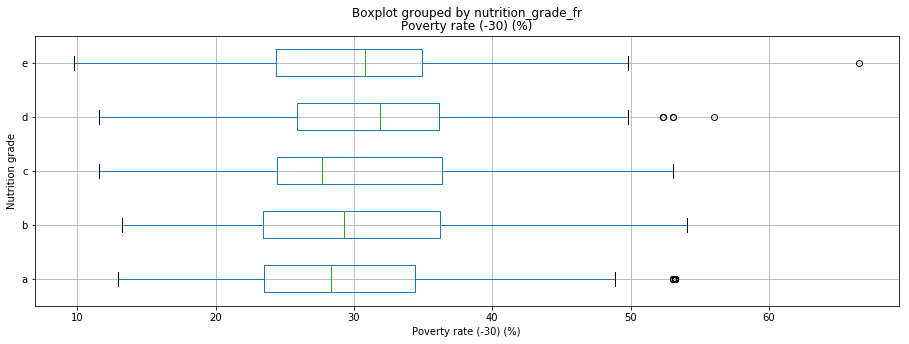

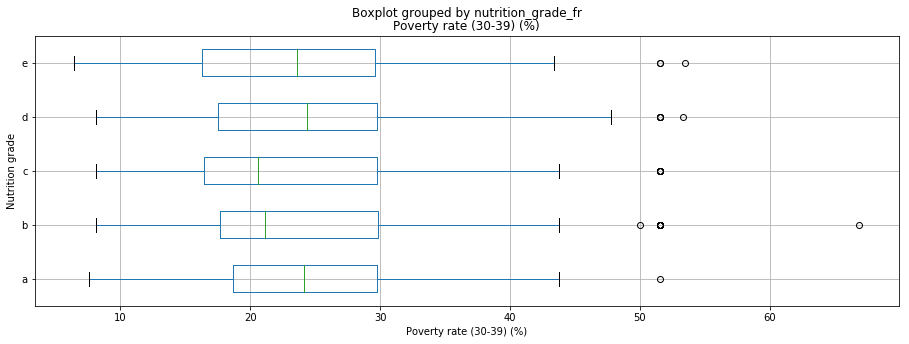

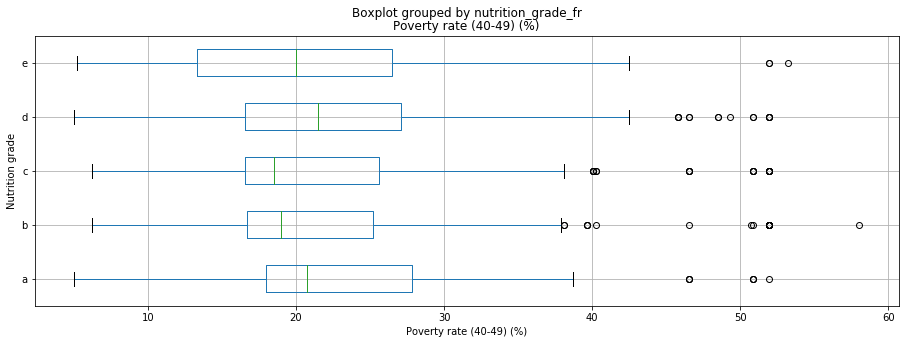

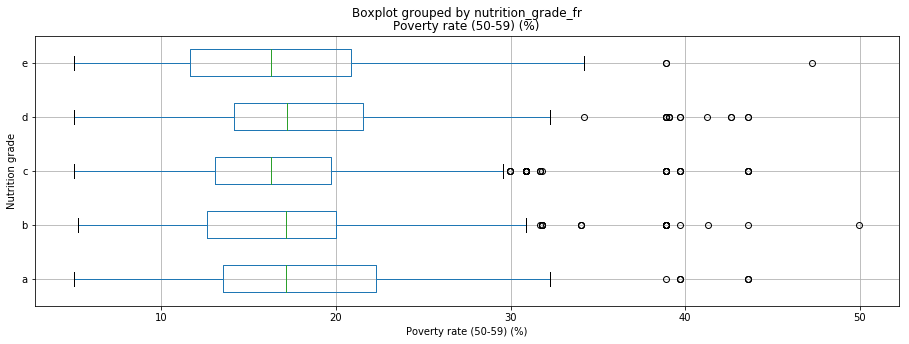

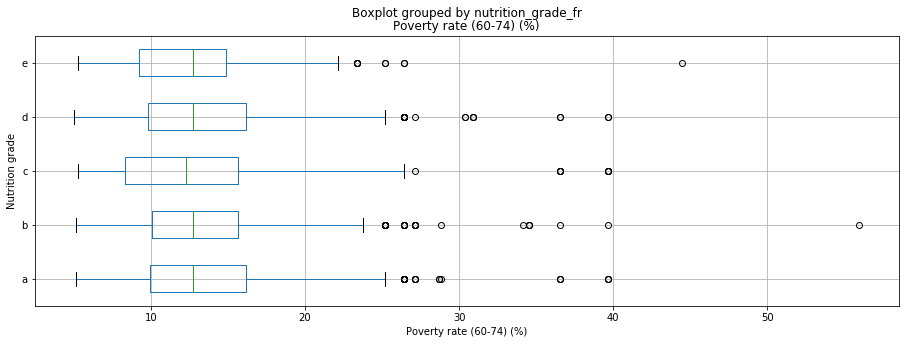

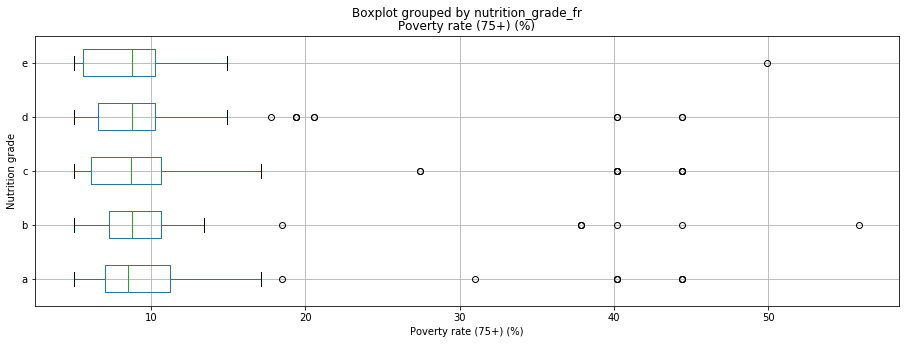

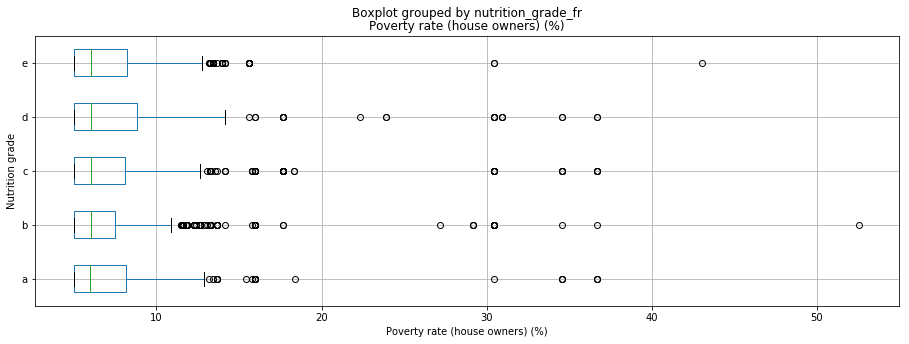

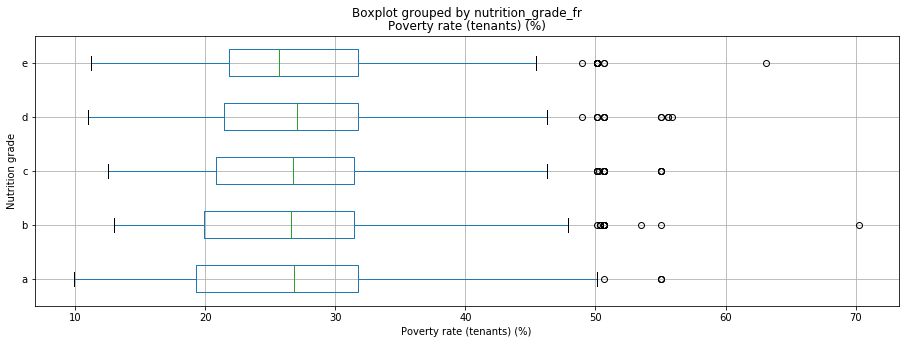

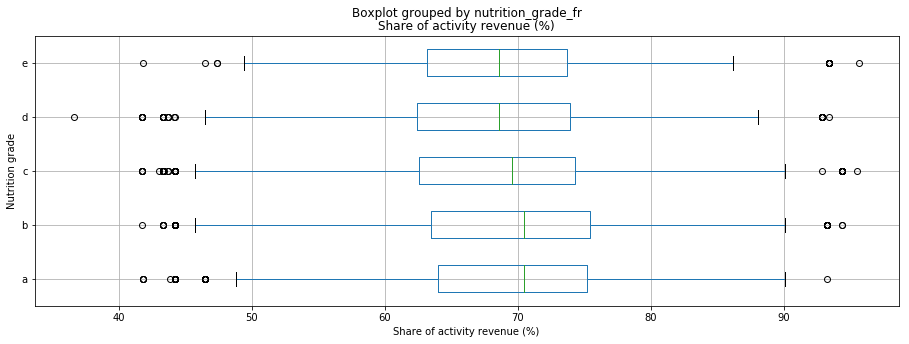

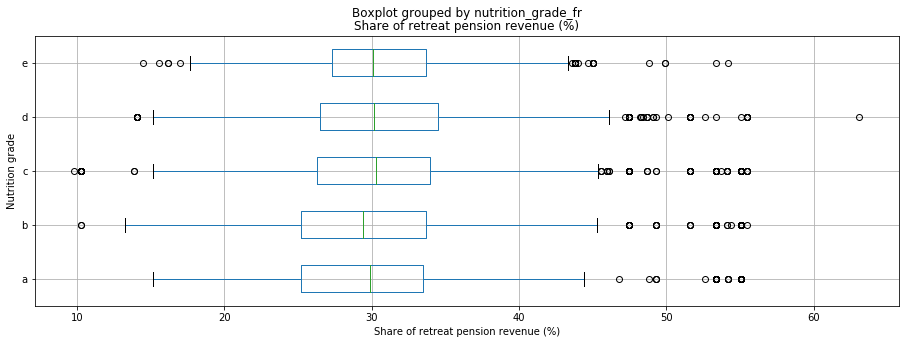

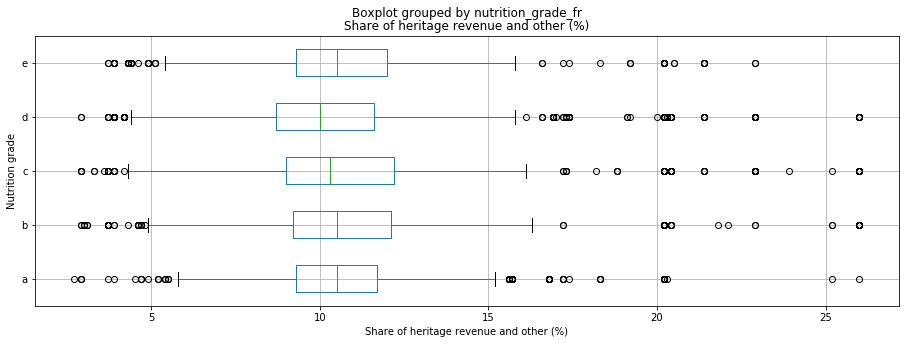

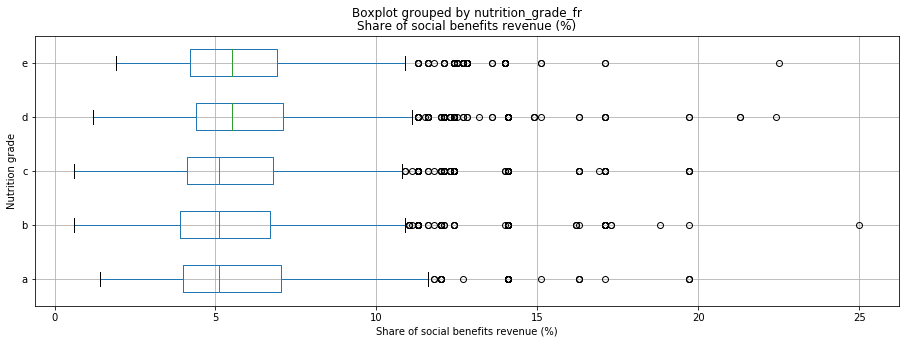

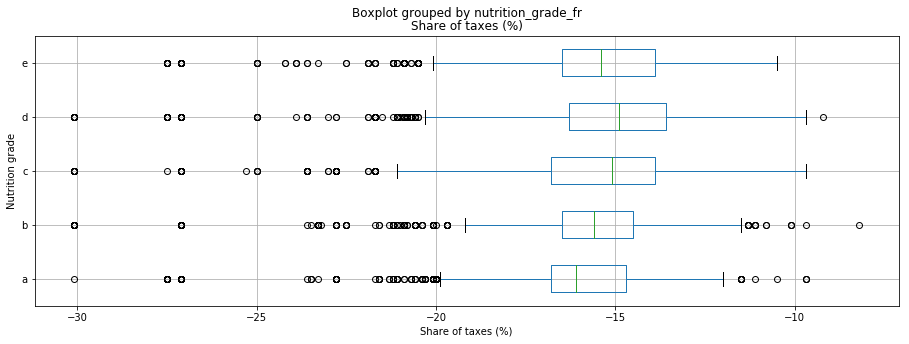

In [7]:
for column in ['Median revenue euros', 'Total poverty rate (%)',
       'Poverty rate (-30) (%)', 'Poverty rate (30-39) (%)',
       'Poverty rate (40-49) (%)', 'Poverty rate (50-59) (%)',
       'Poverty rate (60-74) (%)', 'Poverty rate (75+) (%)',
       'Poverty rate (house owners) (%)', 'Poverty rate (tenants) (%)',
       'Share of activity revenue (%)', 'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)'
              ]:
    dataframe.boxplot(column=column, 
                  by='nutrition_grade_fr', 
                  vert=False, figsize=(15, 5)
                 )
    plt.xlabel(column)#"Mean income of the purchase town (in €)")
    plt.ylabel("Nutrition grade")
    #plt.title("Distribution of the sold food items with regard to the median income of the purchase town.")
    plt.show()

In [8]:
dataframe.columns

Index(['Unnamed: 0', 'city_index', 'food_item_index',
       'city_tag_from_food_item', 'code', 'nutrition_grade_fr',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'serving_size',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'purchase_places',
       'stores', 'countries', 'countries_tags', 'City name',
       'Household inhabitants', 'Median revenue euros',
       'Total poverty rate (%)', 'Poverty rate (-30) (%)',
       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)',
       'nutrition_grade_numeric'],
      dtype='o

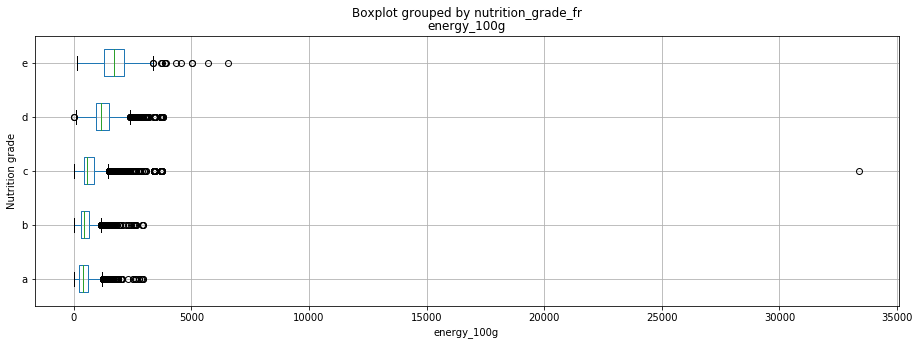

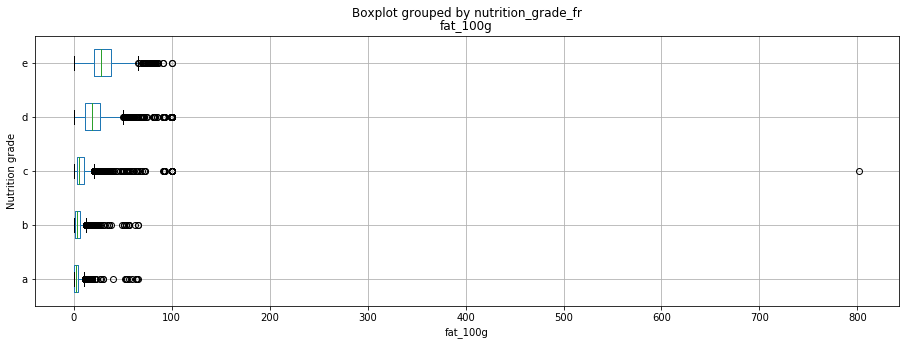

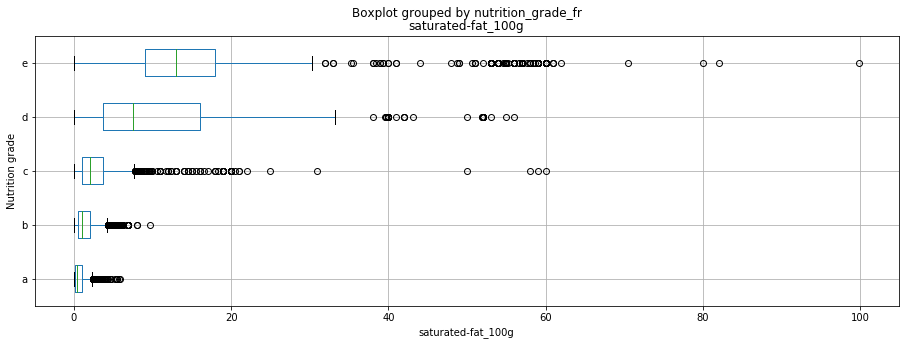

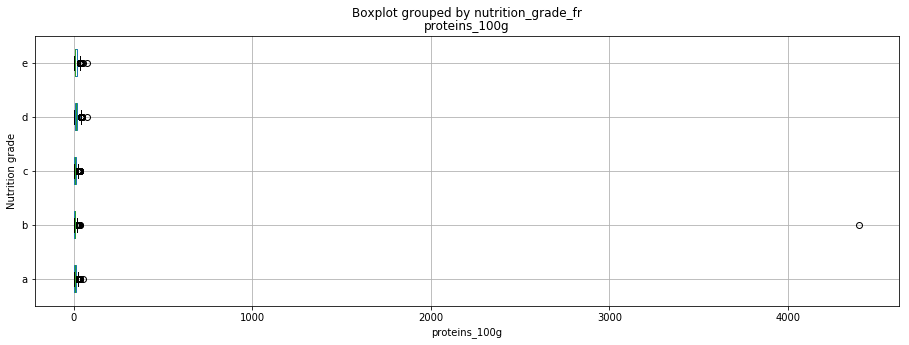

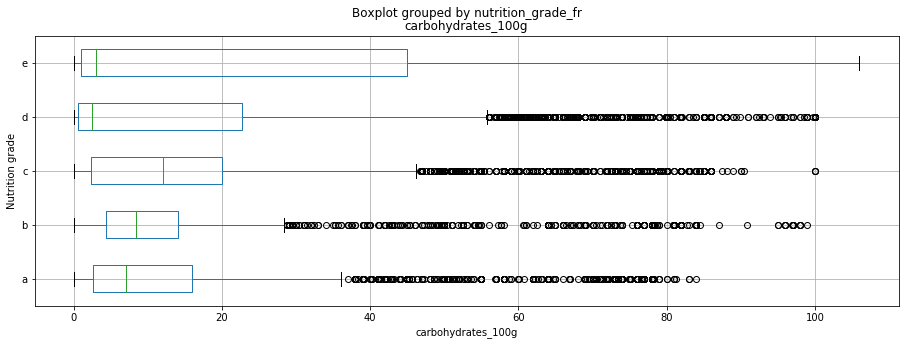

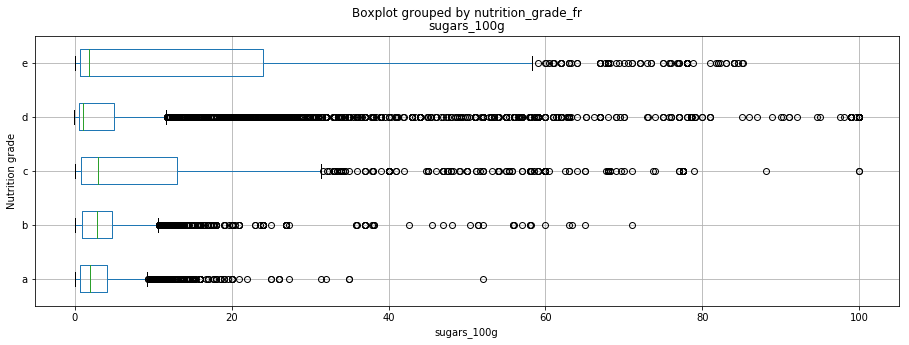

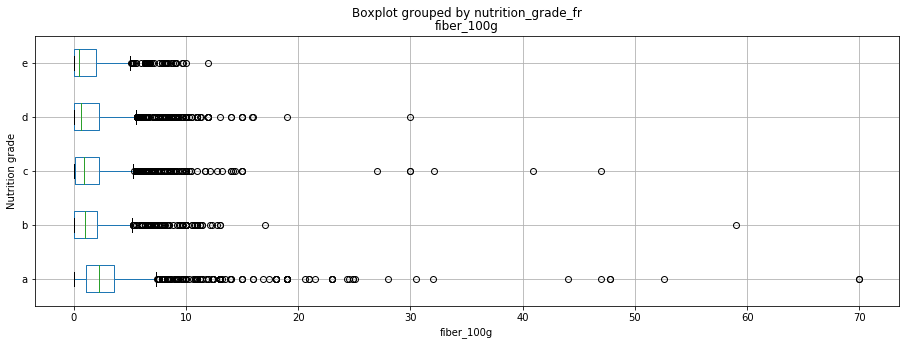

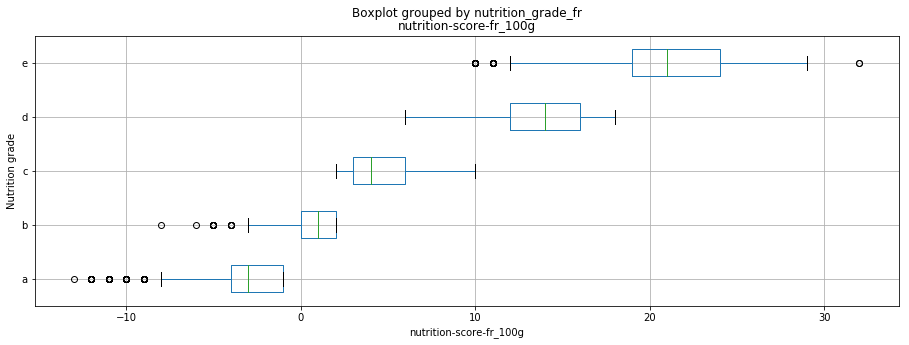

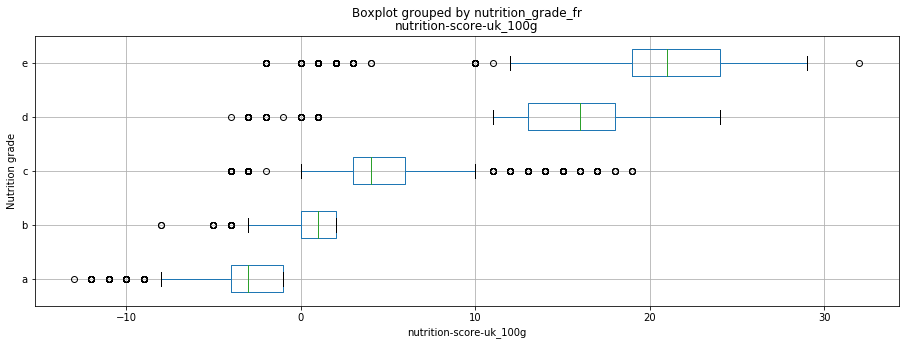

In [9]:
for food_column in ['energy_100g',
       'fat_100g', 'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    dataframe.boxplot(column=food_column, 
                  by='nutrition_grade_fr', 
                  vert=False, figsize=(15, 5)
                 )
    plt.xlabel(food_column)#"Mean income of the purchase town (in €)")
    plt.ylabel("Nutrition grade")
    #plt.title("Distribution of the sold food items with regard to the median income of the purchase town.")
    plt.show()

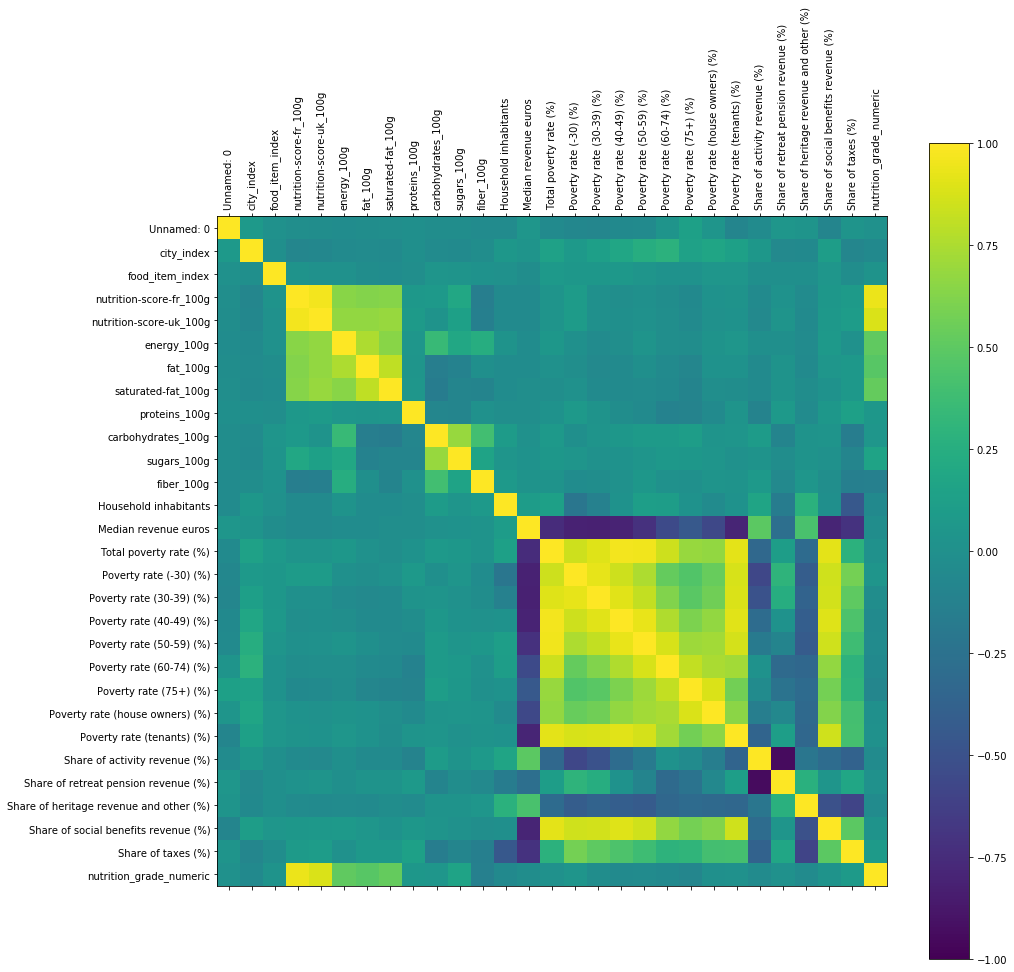

In [10]:
correlations = dataframe.corr()
names = list(correlations.columns)
# plot correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(names), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation='vertical')
plt.show()

We see that there is no correlation between the nutrition grade or any other food-related feature, and the income-related features.

There is however a small (~0.6) positive correlation between the nutrition grade and the amount of energy, fat, and saturated in a food item.

Le score est calculé par un système de points, le score le plus faible étant le meilleur.

- éléments défavorables au score : apport calorique pour 100 grammes, teneur en sucre, en graisses saturées et en sel.

- éléments favorables au score : teneur en fruits, légumes, légumineuses et oléagineux, teneur en fibres, et enfin teneur en protéines.

In [11]:
dataframe.head()

,Unnamed: 0,city_index,food_item_index,city_tag_from_food_item,code,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,serving_size,energy_100g,...,Poverty rate (60-74) (%),Poverty rate (75+) (%),Poverty rate (house owners) (%),Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),nutrition_grade_numeric
0,0,30,357718,belley-ain-france,3307905810084,d,15.0,20.0,NaN,1435.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
1,1,30,357694,belley-ain-france,3307902060086,d,15.0,20.0,NaN,1402.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
2,2,30,357721,belley-ain-france,3307906000064,d,14.0,19.0,150 g,1243.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
3,3,30,357696,belley-ain-france,3307903690121,d,15.0,20.0,NaN,1435.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
4,4,30,357698,belley-ain-france,3307904400125,d,14.0,19.0,NaN,1238.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4


In [12]:
nutri_score = ((dataframe['energy_100g'] / dataframe['energy_100g'].std()) 
+ (dataframe['fat_100g'] / dataframe['fat_100g'].std()) 
+ (dataframe['saturated-fat_100g'] / dataframe['saturated-fat_100g'].std())
+ (dataframe['sugars_100g'] / dataframe['sugars_100g'].std())) 
nutri_score = nutri_score.divide((dataframe['fiber_100g'] / dataframe['fiber_100g'].std()) +
                                 (dataframe['proteins_100g'] / dataframe['proteins_100g'].std()))
nutri_score = nutri_score.replace([np.inf, -np.inf], np.nan)

In [13]:
nutri_score_noNa = dataframe['energy_100g'].fillna(0) / dataframe['energy_100g'].fillna(0).std() 
+ dataframe['fat_100g'].fillna(0) / dataframe['fat_100g'].fillna(0).std()
+ dataframe['saturated-fat_100g'].fillna(0) / dataframe['saturated-fat_100g'].fillna(0).std()
+ dataframe['sugars_100g'].fillna(0) / dataframe['sugars_100g'].fillna(0).std()
nutri_score_noNa = nutri_score_noNa.replace([np.inf, -np.inf], np.nan)

In [14]:
pearson_coeff = dataframe['Median revenue euros'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and median revenue is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and median revenue is: 0.004


In [15]:
pearson_coeff = dataframe['Total poverty rate (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and total poverty rate is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and total poverty rate is: 0.010


In [16]:
pearson_coeff = dataframe['Poverty rate (-30) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people under 30 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people under 30 is: 0.012


In [17]:
pearson_coeff = dataframe['Poverty rate (30-39) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 30 and 39 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 30 and 39 is: 0.004


In [18]:
pearson_coeff = dataframe['Poverty rate (40-49) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 40 and 49 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 40 and 49 is: 0.010


In [19]:
pearson_coeff = dataframe['Poverty rate (50-59) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 50 and 59 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 50 and 59 is: 0.021


In [20]:
pearson_coeff = dataframe['Poverty rate (60-74) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 60 and 74 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 60 and 74 is: 0.013


In [21]:
pearson_coeff = dataframe['Poverty rate (75+) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people older than 75 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people older than 75 is: 0.013


In [22]:
pearson_coeff = dataframe['Share of social benefits revenue (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and the share of social benefits in the income is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and the share of social benefits in the income is: 0.010


In [23]:
dataframe['nutri_score'] = nutri_score_noNa

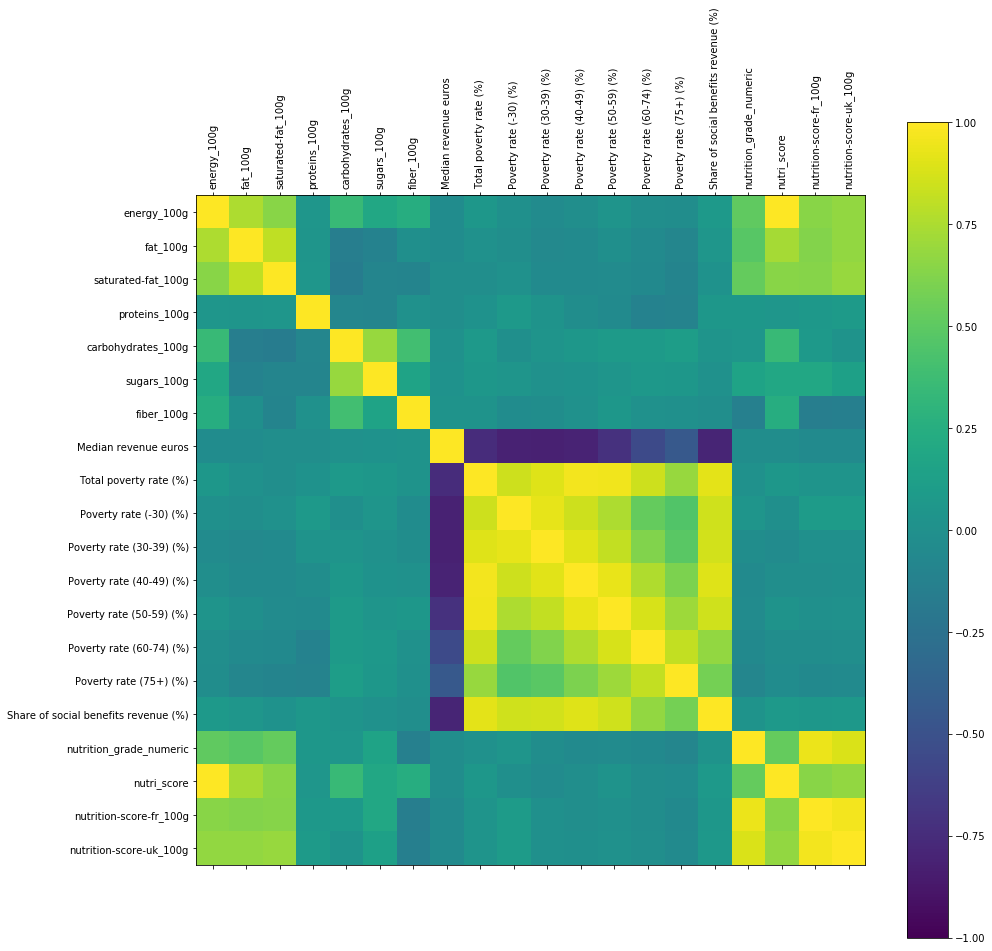

In [24]:
correlations_2 = dataframe[['energy_100g',
                            'fat_100g', 'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                            'sugars_100g', 'fiber_100g', 'Median revenue euros', 'Total poverty rate (%)',
                            'Poverty rate (-30) (%)', 'Poverty rate (30-39) (%)',
                            'Poverty rate (40-49) (%)', 'Poverty rate (50-59) (%)',
                            'Poverty rate (60-74) (%)', 'Poverty rate (75+) (%)',
                            'Share of social benefits revenue (%)', 'nutrition_grade_numeric', 'nutri_score', 
                            'nutrition-score-fr_100g', 'nutrition-score-uk_100g']].corr()
names = list(correlations_2.columns)
# plot correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations_2, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(names), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation='vertical')
plt.show()

# Correlation between stores and quality of the products

In [25]:
store_dataframe = pd.read_csv('../data/processed/clean_food_and_stores.csv')

/home/wilhelm/Documents/EPFL/applied_data_analysis/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
nutrition_store_df = store_dataframe[['store_name', 'nutrition_grade_numeric', 
                                      'nutrition-score-fr_100g', 'nutrition-score-uk_100g']]
nutrition_store_df = nutrition_store_df[nutrition_store_df['nutrition_grade_numeric'] > 0]
nutrition_per_store = nutrition_store_df.groupby('store_name').agg(['mean', 'count', 'median'])
nutrition_per_store.describe()

nutrition_grade_numeric                           \
                         mean        count      median   
count              438.000000   438.000000  438.000000   
mean                 3.122907    55.180365    3.125571   
std                  1.161918   279.600331    1.223430   
min                  1.000000     1.000000    1.000000   
25%                  2.000000     1.000000    2.000000   
50%                  3.000000     2.000000    3.000000   
75%                  4.000000     5.000000    4.000000   
max                  5.000000  3462.000000    5.000000   

      nutrition-score-fr_100g                           \
                         mean        count      median   
count              438.000000   438.000000  438.000000   
mean                 8.320624    55.180365    8.074201   
std                  7.817609   279.600331    8.151082   
min                -10.000000     1.000000  -10.000000   
25%                  2.000000     1.000000    1.000000   
50%                  7.500000     2.000000    6.250000   
75%                 14.000000     5.000000   14.000000   
max                 27.000000  3462.000000   27.000000   

      nutrition-score-uk_100g                           
                         mean        count      median  
count              438.000000   438.000000  438.000000  
mean                 8.595623    55.180365    8.260274  
std                  8.362586   279.600331    8.759608  
min                -10.000000     1.000000  -10.000000  
25%                  2.000000     1.000000    1.000000  
50%                  7.484234     2.000000    5.000000  
75%                 15.916667     5.000000   16.000000  
max                 27.000000  3462.000000   27.000000

In [42]:
nutrition_per_store.columns = ['_'.join(col).strip().strip('_') for col in nutrition_per_store.columns.values]

In [43]:
nutrition_per_store = nutrition_per_store[nutrition_per_store["nutrition_grade_numeric_count"] > 100]
nutrition_per_store.describe()

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
count,25.000000,25.000000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,3.132025,874.080000,3.2,8.086625,874.080000,7.380000,8.372212,874.080000,6.960000
std,0.253527,824.839122,0.5,1.627743,824.839122,3.021727,1.878429,824.839122,3.561718
min,2.526682,111.000000,2.0,4.415313,111.000000,2.000000,4.415313,111.000000,2.000000
25%,3.054054,271.000000,3.0,7.344156,271.000000,5.000000,7.500000,271.000000,5.000000
50%,3.112363,599.000000,3.0,8.023397,599.000000,7.000000,8.444688,599.000000,6.000000
75%,3.271795,1262.000000,3.0,8.847194,1262.000000,10.000000,9.357143,1262.000000,10.000000
max,3.601911,3462.000000,4.0,11.035032,3462.000000,12.500000,11.668790,3462.000000,13.500000


In [44]:
nutrition_per_store.reset_index()
nutrition_per_store

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
store_name,,,,,,,,,
aldi,3.098404,376,3.0,7.763298,376,5.0,8.555851,376,5.0
auchan,3.048739,1785,3.0,7.372549,1785,5.0,7.810644,1785,5.0
banque alimentaire,2.560714,280,2.0,4.467857,280,2.0,4.542857,280,2.0
carrefour,3.112363,3462,3.0,8.023397,3462,6.0,8.027152,3462,5.0
carrefour city,3.271795,195,3.0,8.656410,195,8.0,7.871795,195,5.0
carrefour market,3.097436,975,3.0,7.867692,975,7.0,8.026667,975,5.0
casino,2.898226,1071,3.0,6.660131,1071,4.0,6.383754,1071,3.0
cora,3.185902,1291,3.0,8.385747,1291,8.0,8.691712,1291,7.0
dia,3.436585,410,4.0,10.300000,410,12.0,11.048780,410,13.0


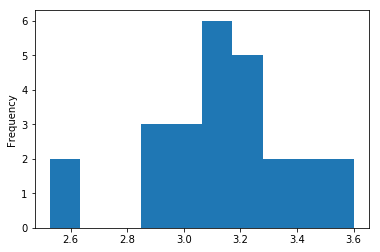

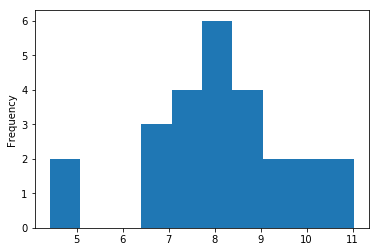

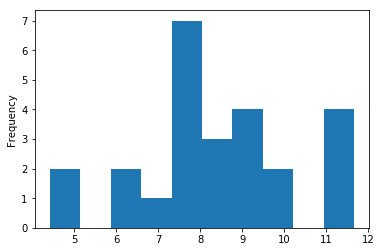

In [46]:
nutrition_per_store['nutrition_grade_numeric_mean'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-fr_100g_mean'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-uk_100g_mean'].plot.hist()
plt.show()

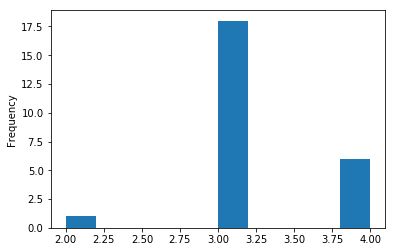

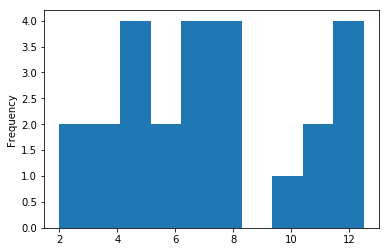

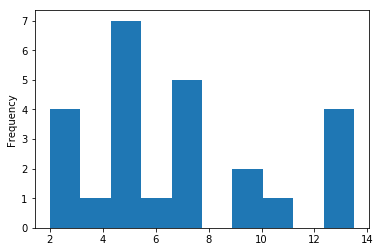

In [47]:
nutrition_per_store['nutrition_grade_numeric_median'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-fr_100g_median'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-uk_100g_median'].plot.hist()
plt.show()

We see that there is no significant difference between the discounters and the main stores. Also, stores for which we have enough data have roughly the same mean and median.

In [48]:
nutrition_per_store[nutrition_per_store['nutrition-score-fr_100g_median'] > 9]

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
store_name,,,,,,,,,
dia,3.436585,410,4.0,10.300000,410,12.0,11.048780,410,13.0
grand frais,3.519337,181,4.0,10.729282,181,12.0,11.016575,181,13.0
leader price,3.294898,980,4.0,9.395918,980,10.5,9.357143,980,10.0
magasins u,3.257681,2441,3.0,8.847194,2441,10.0,9.523966,2441,10.0
netto,3.601911,314,4.0,11.035032,314,12.5,11.668790,314,13.0
simply market,3.306273,271,4.0,9.059041,271,11.0,9.830258,271,11.0
u express,3.401235,162,4.0,10.154321,162,12.0,11.296296,162,13.5


In [49]:
nutrition_per_store[nutrition_per_store['nutrition-score-uk_100g_median'] >= 9]

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
store_name,,,,,,,,,
dia,3.436585,410,4.0,10.300000,410,12.0,11.048780,410,13.0
grand frais,3.519337,181,4.0,10.729282,181,12.0,11.016575,181,13.0
leader price,3.294898,980,4.0,9.395918,980,10.5,9.357143,980,10.0
magasins u,3.257681,2441,3.0,8.847194,2441,10.0,9.523966,2441,10.0
netto,3.601911,314,4.0,11.035032,314,12.5,11.668790,314,13.0
simply market,3.306273,271,4.0,9.059041,271,11.0,9.830258,271,11.0
u express,3.401235,162,4.0,10.154321,162,12.0,11.296296,162,13.5


# Visualization

In [31]:
import seaborn as sns
import folium
import json
import re
from IPython.core.display import display, HTML

In [32]:
map_df = pd.read_csv("../data/processed/clean_food_cities_arrond.csv")

/home/wilhelm/Documents/EPFL/applied_data_analysis/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (5,39,40,42,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
df_revenue = map_df[['custom_arrondissement_code', 'Median revenue euros']].dropna().groupby('custom_arrondissement_code').median().reset_index()

In [57]:
df_revenue.describe()

,Median revenue euros
count,433.000000
mean,19965.737899
std,2415.767272
min,13812.413793
25%,18700.333333
50%,19660.666667
75%,20798.888889
max,37125.625000


In [35]:
map_revenue = folium.Map(location=[46.9, 2.7], tiles='cartodbpositron', zoom_start=6)
map_revenue

In [36]:
scale = np.linspace(np.min(df_revenue['Median revenue euros']), np.max(df_revenue['Median revenue euros']), 6)
scale

array([13812.4137931 , 18475.05603448, 23137.69827586, 27800.34051724,
       32462.98275862, 37125.625     ])

In [37]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)

In [38]:
# geojson: https://github.com/gregoiredavid/france-geojson
arr_borders = json.load(open("../data/raw/arrondissements.geojson"))

In [39]:
# This does work
map_revenue.choropleth(geo_data=arr_borders, 
                   data=df_revenue, 
                   columns=['custom_arrondissement_code', 'Median revenue euros'],
                   key_on='feature.properties.code',
                   legend_name='Median revenue in euros',
                   threshold_scale=list(scale),
                   fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

map_revenue.save("../data/processed/map_revenue.html")

In [40]:
display(HTML("<a href='../data/processed/map_revenue.html' target='_blank'>Median revenue</a>"))

In [58]:
df_nutrition_geo = map_df[
    ['custom_arrondissement_code', 'nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
].dropna().groupby('custom_arrondissement_code').median().reset_index()

In [59]:
df_nutrition_geo.describe()

,nutrition_grade_numeric,nutrition-score-fr_100g,nutrition-score-uk_100g
count,427.000000,427.000000,427.000000
mean,3.299766,8.928571,9.523419
std,1.061633,7.085175,7.974764
min,1.000000,-10.000000,-10.000000
25%,3.000000,3.000000,3.000000
50%,3.000000,10.000000,10.000000
75%,4.000000,14.000000,17.000000
max,5.000000,26.000000,26.000000


In [60]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(df_nutrition_geo[column]), np.max(df_nutrition_geo[column]), 6)
    map_nutrition.choropleth(geo_data=arr_borders, 
                           data=df_nutrition_geo, 
                           columns=['custom_arrondissement_code', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [65]:
df_nutrition_revenue_geo = map_df[
    ['custom_arrondissement_code', 'Median revenue euros', 'nutrition_grade_numeric', 
     'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
].dropna().groupby('custom_arrondissement_code').agg({
    'Median revenue euros': ['mean', 'median'],
    'nutrition_grade_numeric': ['mean', 'median'],
    'nutrition-score-fr_100g': ['mean', 'median'],
    'nutrition-score-uk_100g': ['mean', 'median'],
}).reset_index()
df_nutrition_revenue_geo.columns = ['_'.join(col).strip().strip('_') for col in df_nutrition_revenue_geo.columns.values]
for measure in ['mean', 'median']:
    for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
        df_nutrition_revenue_geo[
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        ] = df_nutrition_revenue_geo[
            '{column}_{measure}'.format(column=column, measure=measure)
        ] / df_nutrition_revenue_geo['Median revenue euros_{measure}'.format(measure=measure)]
        map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
        scale = np.linspace(
            np.min(df_nutrition_revenue_geo[
                'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
            ]), 
            np.max(df_nutrition_revenue_geo[
                'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
            ]), 6)
        map_nutrition.choropleth(geo_data=arr_borders, 
                               data=df_nutrition_revenue_geo, 
                               columns=['custom_arrondissement_code', 
                                        'comparison_revenue_{column}_{measure}'
                                        .format(column=column, measure=measure)],
                               key_on='feature.properties.code',
                               legend_name='comparison_revenue_{column}_{measure}'
                                 .format(column=column, measure=measure),
                               threshold_scale=list(scale),
                               fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                          )

        map_nutrition.save("../data/processed/map_{}.html".format(
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        ))
        display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        )))